In [1]:
import random
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data import DataLoader
from IPython.display import clear_output

from running_mean_std import RunningMeanStd

In [2]:
SEED = 5
BATCH_SIZE = 2048
P_LR = 3e-4
V_LR = 1e-3
ITER = 80
CLIP = 0.2
GAMMA = 0.999
LAMBDA = 0.97
BETA = 3.0
# ENT_COEF = 0.0
GRAD_NORM = False
OBS_NORM = True
VIEW_CURVE = True

# set device
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

In [3]:
class ActorCriticNet(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()
        h = 32
        self.pol = nn.Sequential(
            nn.Linear(obs_space, h),
            nn.Tanh(),
            nn.Linear(h, h),
            nn.Tanh(),
            nn.Linear(h, action_space)
        )
        self.val = nn.Sequential(
            nn.Linear(obs_space, h),
            nn.Tanh(),
            nn.Linear(h, h),
            nn.Tanh(),
            nn.Linear(h, 1)
        )
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        logit = self.pol(x).reshape(x.shape[0], -1)
        log_p = self.log_softmax(logit)
        v = self.val(x).reshape(x.shape[0], 1)
        return log_p, v

In [4]:
losses = []
kl_divs = []

def learn(net, old_net, optimizer, train_memory):
    net.train()
    old_net.train()
    dataloader = DataLoader(
            train_memory,
            shuffle=False,
            batch_size=BATCH_SIZE,
            pin_memory=True,
            num_workers=0,
        )
    for _ in range(ITER):        
        for i, (s, a, ret, adv) in enumerate(dataloader):
            s = s.to(device).float()
            a = a.to(device).long()
            ret = ret.to(device).float()
            adv = adv.to(device).float()
            
            with torch.no_grad():
                log_p_old, v_old = old_net(s)
                log_p_act_old = log_p_old[range(BATCH_SIZE), a]

            log_p, v = net(s)
            log_p_act = log_p[range(BATCH_SIZE), a]
            p_ratio = (log_p_act - log_p_act_old).exp()
            p_ratio_clip = torch.clamp(p_ratio, 1 - CLIP, 1 + CLIP)
            p_loss = -(torch.min(p_ratio * adv, p_ratio_clip * adv).mean())
#             kl_div = (log_p.exp() * (log_p - log_p_old)).sum(dim=-1)
#             p_loss = -(p_ratio * adv - BETA * kl_div).mean()
            v_loss = (ret - v).pow(2).mean()
#             log_p, _ = net(s)
#             entropy = -(log_p.exp() * log_p).sum(dim=1).mean()
            # loss
#             loss = p_loss + v_loss - ENT_COEF * entropy
            kl_div = ((log_p.exp() * (log_p - log_p_old)).sum(dim=-1).mean()).detach().item()
            loss = p_loss + v_loss
            losses.append(loss.item())
            kl_divs.append(kl_div)
            if kl_div <= 0.01 * 1.5:
                optimizer[0].zero_grad()
                p_loss.backward()
                if GRAD_NORM:
                    nn.utils.clip_grad_norm_(net.parameters() , max_norm=1.0)
                optimizer[0].step()
            else:
                if not VIEW_CURVE:
                    print("Pass the Pi update!")
            optimizer[1].zero_grad()
            v_loss.backward()
            if GRAD_NORM:
                nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
            optimizer[1].step()


def get_action_and_value(obs, old_net):
    old_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        log_p, v = old_net(state)
        m = Categorical(log_p.exp())
        action = m.sample()
    return action.item(), v.item()


def compute_adv_with_gae(rewards, values, roll_memory):
    rew = np.array(rewards, np.float32)
    val = np.array(values[:-1], np.float32)
    _val = np.array(values[1:], np.float32)
    delta = rew + GAMMA * _val - val
    dis_r = np.array([GAMMA**(i) * r for i, r in enumerate(rewards)], np.float32)
    gae_dt = np.array([(GAMMA * LAMBDA)**(i) * dt for i, dt in enumerate(delta.tolist())], np.float32)
    for i, data in enumerate(roll_memory):
        data.append(sum(dis_r[i:] / GAMMA**(i)))
        data.append(sum(gae_dt[i:] / (GAMMA * LAMBDA)**(i)))

    rewards.clear()
    values.clear()
    return roll_memory


def plot():
    clear_output(True)
    plt.figure(figsize=(16, 5))
    plt.subplot(131)
    plt.plot(ep_rewards, alpha=0.5)
    plt.subplot(131)
    plt.plot(reward_eval)
    plt.title(f'Reward: {reward_eval[-1]:.0f}')
    if losses:
        plt.subplot(132)
        plt.plot(losses, alpha=0.5)
        plt.title(f'Loss: {losses[-1]:.2f}')
        plt.subplot(133)
        plt.plot(kl_divs, alpha=0.5)
        plt.title(f'kl_div: {kl_divs[-1]:.4f}')
    plt.show()

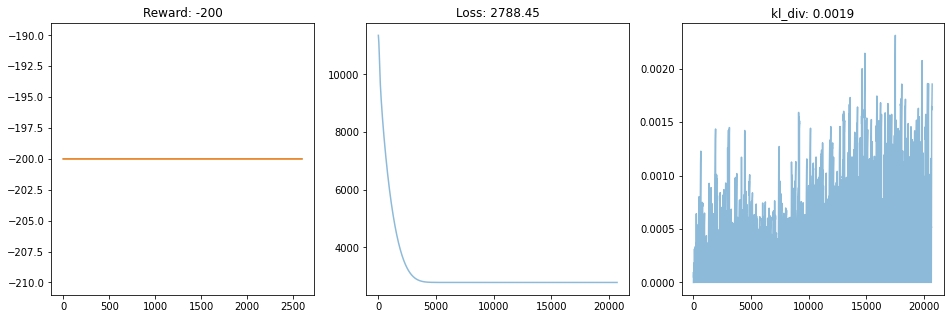

KeyboardInterrupt: 

In [5]:
# make an environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')

env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = int(1e6 / env.spec.max_episode_steps)
roll_len = 2048
n_eval = 100

print(f"n_episodes: {n_episodes}")
print(f"reward_threshold: {env.spec.reward_threshold}")

# global values
steps = 0
ep_rewards = []
reward_eval = []
is_rollout = False
is_solved = False

# make memories
train_memory = []
roll_memory = []
rewards = []
values = []
norm_obs = RunningMeanStd(shape=env.observation_space.shape)

# make nerual networks
net = ActorCriticNet(obs_space, action_space).to(device)
old_net = deepcopy(net)

param_p = [p for n, p in net.named_parameters() if 'pol' in n]
param_v = [p for n, p in net.named_parameters() if 'val' in n]
optim_p = torch.optim.AdamW(param_p, lr=P_LR, eps=1e-6, weight_decay=0.01)
optim_v = torch.optim.AdamW(param_v, lr=V_LR, eps=1e-6, weight_decay=0.01)
optimizer = [optim_p, optim_v]

# play!
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
#         env.render()
        if OBS_NORM:
            norm_obs.update(np.array([obs]))
            obs_norm = np.clip((obs - norm_obs.mean) / np.sqrt(norm_obs.var), -10, 10)
            action, value = get_action_and_value(obs_norm, old_net)
        else:
            action, value = get_action_and_value(obs, old_net)
        
        _obs, reward, done, _ = env.step(action)

        # store
        if OBS_NORM:
            roll_memory.append([obs_norm, action])
        else:
            roll_memory.append([obs, action])
            

        rewards.append(reward)
        values.append(value)

        obs = _obs
        steps += 1
        ep_reward += reward

        if done or steps % roll_len == 0:
            if OBS_NORM:
                norm_obs.update(np.array([_obs]))
            if done:
                _value = 0.
            else:
                if OBS_NORM:
                    _obs_norm = np.clip((_obs - norm_obs.mean) / np.sqrt(norm_obs.var), -10, 10)
                    _, _value = get_action_and_value(_obs_norm, old_net)
                else:
                    _, _value = get_action_and_value(_obs, old_net)

            values.append(_value)
            train_memory.extend(compute_adv_with_gae(rewards, values, roll_memory))
            roll_memory.clear()

            if steps % roll_len == 0:
                # adv normalize
                advs = []
                for m in train_memory:
                    advs.append(m[3])
                advs = np.array(advs)
                for m in train_memory:
                    m[3] = (m[3] - np.mean(advs)) /  np.std(advs)
                
                learn(net, old_net, optimizer, train_memory)
                old_net.load_state_dict(net.state_dict())
                train_memory.clear()
                break

    if done:
        ep_rewards.append(ep_reward)
        reward_eval.append(np.mean(ep_rewards[-n_eval:]))
        if VIEW_CURVE:
            plot()
        else:
            print(f'{i:3} Episode in {steps:5} steps, reward {ep_reward:.2f}')

        if len(ep_rewards) >= n_eval:
            if reward_eval[-1] >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, steps))
                torch.save(net.state_dict(),
                           f'./test/saved_models/{env.spec.id}_ep{i}_clear_model_ppo_st.pt')
                break
env.close()

In [ ]:
# !jupyter nbconvert --to script ppo_discrete_step_test.ipynb